In [1]:
import pandas as pd
import numpy as np
import re
import glob
import os
import datetime
import matplotlib.pyplot as plt

### env variables

In [2]:
BASE_PATH = '../data/pcs-scraping'
RESULTS_PATH = '../data/pcs-scraping/results/rider'
RANKINGS_PATH = '../data/pcs-scraping/pcs-rankings/rider'
TEAMS_PATH = '../data/pcs-scraping/teams/rider'
CALENDARS_PATH = '../data/pcs-scraping/calendars'
STARTLISTS_PATH = '../data/pcs-scraping/startlists'
RACERESULTS_PATH = '../data/pcs-scraping/race_results'

### Load data

In [3]:
rider_names = list(pd.read_csv('../data/pcs-scraping/rider_names.csv'))

In [4]:
rider_name = rider_names[0]

df_rider = {rider_name: {}}

for file in glob.glob(os.path.join(RESULTS_PATH, rider_name, '*.csv')):
    
    year = re.search('\d{4}', file).group(0)
    df_rider[rider_name][year] = pd.read_csv(file)


In [5]:
df_rider[rider_name]['2021']

,Date,Result,GC,Race,Distance,PointsPCS,PointsUCI
0,09.10,1,NaN,Il Lombardia (1.UWT),239.0,275.0,500.0
1,06.10,4,NaN,Milano - Torino (1.Pro),190.0,50.0,100.0
2,05.10,3,NaN,Tre Valli Varesine (1.Pro),196.7,60.0,125.0
3,02.10,DNF,NaN,Giro dell'Emilia (1.Pro),195.3,NaN,NaN
4,26.09,37,NaN,World Championships - Road Race (WC),268.3,15.0,10.0
...,...,...,...,...,...,...,...
79,25.02,2,1.0,Stage 5 - Fujairah Marine Club › Jebel Jais,170.0,20.0,15.0
80,24.02,20,1.0,Stage 4 - Al Marjan Island › Al Marjan Island,204.0,NaN,NaN
81,23.02,1,1.0,Stage 3 - Strata Manufactoring › Jebel Hafeet,166.0,35.0,40.0
82,22.02,4,1.0,Stage 2 (ITT) - Al Hudayriat Island › Al Huday...,13.0,9.0,NaN


# Expert model

- competitor with most victories/top X in the last N races is predicted as race winner

### Data Normalization

In [19]:
year = '2021'
df_season = {year: {}}
df_res = {}

for rider_name in rider_names[:100]:
    for file in glob.glob(os.path.join(RESULTS_PATH, rider_name, f'{year}.csv')):

        df_season[year][rider_name] = pd.read_csv(file)
        
        # Filter NaN values and non int
        df_results = df_season[year][rider_name][['Date', 'Result', 'Race']].dropna(axis=0)
        df_results = df_results[(df_results.Result != 'DNF') & (df_results.Result != 'DNS') & (df_results.Result != 'DSQ') & (df_results.Result != 'OTL')]
        results = [int(x) for x in df_results.Result]
        
        df_results['Result'] = results
        df_res[rider_name] = df_results

### Compute Model Features (Win Statistics)

In [7]:
def GetStats(df):
    
    stats = {}
    
    stats['wins'] = (df.Result == 1).sum()
    stats['top_3'] = (df.Result <= 3).sum()
    stats['top_5'] = (df.Result <= 5).sum()
    stats['top_10'] = (df.Result <= 10).sum()
    stats['top_20'] = (df.Result <= 20).sum()
    
    return stats

In [21]:
year = '2021'
stats = {year: {}}

for rider_name in rider_names[:10]:
    
    stats[year][rider_name] = GetStats(df_res[rider_name])

In [9]:
stats['2021']['adam-yates']

{'wins': 1, 'top_3': 6, 'top_5': 13, 'top_10': 20, 'top_20': 30}

### Rename result column with rider name

In [ ]:
for rider_name in rider_names[:10]:
    
    df_res[rider_name].rename(columns={'Result': f'Result-{rider_name}'}, inplace=True)

### Merge dataframes

In [ ]:
pd.merge(df_res['wout-van-aert'], df_res['mathieu-van-der-poel'], on='Race')

 # Compute Features for each participant at race

### Get race startlist

In [10]:
startlist = pd.read_csv(os.path.join(STARTLISTS_PATH, 'giro-d-italia', '2021', 'startlist.csv'))
startlist.head()

,#,Ridername,Team
0,1,Affini Edoardo,Team Jumbo-Visma
1,2,Albanese Vincenzo,EOLO-Kometa
2,3,Aleotti Giovanni,BORA - hansgrohe
3,4,Almeida João,Deceuninck - Quick Step
4,5,Arashiro Yukiya,Bahrain - Victorious


### Normalize startlist names

In [11]:
def normalize_name(name):
    
    norm_name = '-'.join(reversed(name.lower().replace(' ', '-').split('-')))
    
    return norm_name

In [12]:
startlist_norm = [normalize_name(name) for name in startlist.Ridername]
startlist_norm

['edoardo-affini',
 'vincenzo-albanese',
 'giovanni-aleotti',
 'joão-almeida',
 'yukiya-arashiro',
 'nikias-arndt',
 'matteo-badilatti',
 'romain-bardet',
 'enrico-battaglin',
 'samuele-battistella',
 'manuel-belletti',
 'cesare-benedetti',
 'george-bennett',
 'natnael-berhane',
 'egan-bernal',
 'alberto-bettiol',
 'patrick-bevin',
 'françois-bidard',
 'pello-bilbao',
 'maciej-bodnar',
 'geoffrey-bouchard',
 'koen-bouwman',
 'gianluca-brambilla',
 'matthias-brändle',
 'emanuel-buchmann',
 'klever-jonathan-caicedo',
 'victor-campenaerts',
 'giovanni-carboni',
 'simon-carr',
 'hugh-carthy',
 'damiano-caruso',
 'jonathan-castroviejo',
 'dario-cataldo',
 'rémi-cavagna',
 'alexander-jefferson-cepeda',
 'clément-champoussin',
 'mark-christian',
 'giulio-ciccone',
 'davide-cimolai',
 'simone-consonni',
 'valerio-conti',
 'alessandro-covi',
 'dries-bondt-de',
 'jasper-buyst-de',
 'thomas-gendt-de',
 'koen-kort-de',
 'alessandro-marchi-de',
 'david-dekker',
 'nico-denz',
 'márton-dina',
 'joe-d

### Get competing riders

In [22]:
riders_competing = []

for rider_name in rider_names[:100]:
    if rider_name in startlist_norm:
        riders_competing.append(rider_name)
        
riders_competing

['egan-bernal',
 'joão-almeida',
 'matej-mohorič',
 'remco-evenepoel',
 'tim-merlier',
 'bauke-mollema',
 'giacomo-nizzolo',
 'aleksandr-vlasov',
 'simon-yates',
 'damiano-caruso',
 'diego-ulissi',
 'fausto-masnada',
 'filippo-ganna',
 'romain-bardet',
 'peter-sagan',
 'mikel-landa',
 'pello-bilbao',
 'elia-viviani',
 'caleb-ewan',
 'gianni-moscon',
 'gianni-vermeersch',
 'gino-mäder',
 'alessandro-covi']

### Normalize dates to datetime

In [15]:
def convert_to_datetime(date_string, year):
    
    return datetime.datetime.strptime(date_string, '%d.%m').replace(year=year)

def normalize_date_data(riders_competing):
    
    df = {k: v for k, v in df_res.items() if k in riders_competing}
    
    for rider in riders_competing:
        datetimes = [convert_to_datetime(date, int(year)) for date in df[rider].Date]
        df[rider].Date = datetimes
    
    return df

def create_date_mask(df, event, year, timedelta, riders_competing):
    
    calendar = pd.read_csv(os.path.join(CALENDARS_PATH, f'{year}.csv'))
    event_date = calendar[calendar.Race.str.contains(event)].Date.values[0].split('- ')[-1]
    
    event_date = datetime.datetime.strptime(f'{event_date}.{year}', '%d.%m.%Y')
    start_date = event_date - datetime.timedelta(weeks=timedelta)
    
    for rider in riders_competing:
        mask = (df[rider].Date > start_date) & (df[rider].Date <= event_date)
        df[rider] = df[rider].loc[mask]

    return df

def compute_features(riders_competing, event, year, timedelta):
    
    df = normalize_date_data(riders_competing)
        
    df_mask = create_date_mask(df, event, year, timedelta, riders_competing)
    
    stats = {}
    for rider in riders_competing:
        stats[rider] = GetStats(df_mask[rider])
        
    return stats

In [23]:
features = compute_features(riders_competing, "Giro d'Italia", '2021', 12)

In [72]:
weights = np.array([10, 8, 6, 4, 2])

score = {}
for rider in riders_competing:
    score[rider] = [np.average(np.array(list(features[rider].values())), weights=weights)]
    
#score = pd.DataFrame({'Score': score}).sort_values(by='Score', ascending=False)

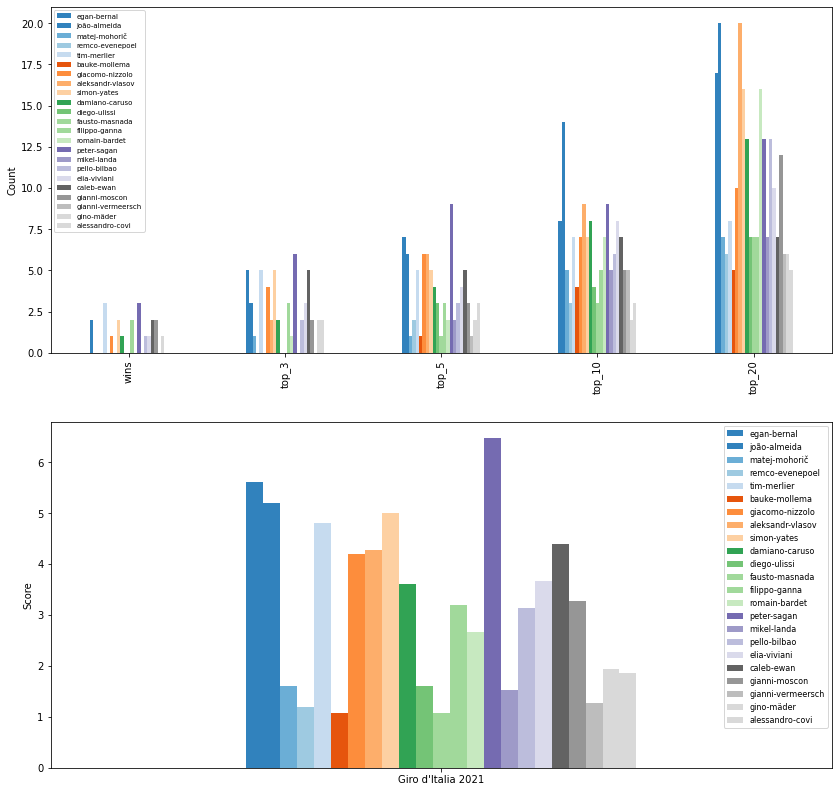

In [83]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14, 14))
pd.DataFrame(features).plot(kind='bar', ax=ax1, colormap='tab20c')
pd.DataFrame(score).plot(kind='bar', ax=ax2, colormap='tab20c')

ax1.set_ylabel('Count')
ax2.set_ylabel('Score')
ax2.set_xticklabels(["Giro d'Italia 2021"], rotation=0)
ax1.legend(prop={'size': 7})
ax2.legend(prop={'size': 8})

plt.show()

# Model Hyperparams

- timeframe to consider when computing win features (eg. 2 weeks, 2 months, etc.)
- how many (which) win features to include ?
- weighting (linear, exp, etc.) of features to create score ?